# Post training quantization tutorial for resnext. 



We first start by doing the necessary imports

In [2]:
from __future__ import print_function, division, absolute_import
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
import os
import time
import sys
import torch.quantization

# Setup warnings
import warnings
warnings.filterwarnings(
    action='ignore',
    category=DeprecationWarning,
    module=r'.*'
)
warnings.filterwarnings(
    action='default',
    module=r'torch.quantization'
)

# Disable OMP 
# Set number of threads to one for single threaded comparison, quantized models run single threaded
import ctypes
gomp_file = ctypes.util.find_library('gomp')
gomp = ctypes.cdll.LoadLibrary(gomp_file)
gomp.omp_set_num_threads(1)
torch.set_num_threads(1)

We first start by specifying locations for models and data

In [3]:
arch='ResNet-50' 
if arch =='ResNext-101-32x8d':
    layers = [3, 4, 23, 3]
    groups=32 
    width_per_group=8
    saved_model_dir = '/mnt/vol/gfsai-oregon/ai-group/users/raghuraman/torchvision/resnext/'
    float_model_file = 'resnext101_32x8d-8ba56ff5.pth'
if arch =='ResNet-50':
    layers = [3, 4, 6, 3]
    groups=1
    width_per_group=64
    saved_model_dir = '/mnt/vol/gfsai-oregon/ai-group/users/raghuraman/torchvision/resnet/' 
    float_model_file = 'resnet50-19c8e357.pth'

data_dir = '/mnt/vol/gfsai-oregon/ai-group/users/raghuraman/imagenet_sample/' 
quantized_model_state_dict_file = arch+'quantized-state-dict.pth'
quantized_model_file = arch+'quantized.pth'
scripted_quantized_model_file = arch+'quantized_scripted.pth'

We then setup code for evaluating model accuracy

In [4]:
def get_imagenet_val_dataset(args_data):
    valdir = os.path.join(args_data, 'val')

    ds = datasets.ImageFolder(
        valdir,
        transforms.Compose(
            [
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        ),
    )
    return ds


In [5]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)
    
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
    #    print(target.view(1, -1).expand_as(pred), pred)
        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

def evaluate(model,data_loader, num_batches):
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    output_result = []

    with torch.no_grad():
        for i, (images, target) in enumerate(data_loader):
            if i < num_batches:
                output = model(images)
                print('Batch index', i)
                acc1, acc5 = accuracy(output, target, topk=(1, 5))
                top1.update(acc1[0], images.size(0))
                top5.update(acc5[0], images.size(0))
                print(' * Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'
                      .format(top1=top1, top5=top5))
                output_result.append(output)
            if i == num_batches - 1:
                return (top1, top5, output_result)

Lets first load a floating point pre-trained model and making sure that it has good accuracy.
Since running on imagenet would take too long, lets test it on 5 images.

In [6]:
float_model =torchvision.models.resnet.ResNet(torchvision.models.resnet.Bottleneck, layers, groups=groups, width_per_group=width_per_group)
state_dict = torch.load(saved_model_dir+float_model_file)
float_model.load_state_dict(state_dict)

<All keys matched successfully>

In [7]:
float_model.to('cpu')
float_model.eval()
batch_size = 10
val_loader = DataLoader(get_imagenet_val_dataset(data_dir), batch_size)
top1,top5,ref_output = evaluate(float_model,val_loader,  5)

Batch index 0
 * Acc@1 90.000 Acc@5 100.000
Batch index 1
 * Acc@1 90.000 Acc@5 95.000
Batch index 2
 * Acc@1 93.333 Acc@5 96.667
Batch index 3
 * Acc@1 87.500 Acc@5 97.500
Batch index 4
 * Acc@1 90.000 Acc@5 98.000


We see that we got 4 out of the first 5 images right. Now lets start the quantization process.
Eager mode quantization requires changing the model definition, based on the following rules:

    1. Replace add, cat and mul operations with modules. The function torch.quantization.floatFunctional() makes this easy.
    
    2. Insert QuantStub/DeQuantStub modules to specify where we need to quantize/dequantize activations.
    
    3. Ensure that modules have unique names: Quantization stores state in each module instance to
       log statistics and therefore the instances have to be unique.

    
    To address this, we modify the bottleneck module in torchvision.models.resnet
    
    
    We first show the original module (source: https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py#L75)

In [8]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out



We have modified the module below with the following changes
    1. Unique names for all ReLU modules
    2. Replace out+=identity with a module created using nn.quantized.Floatfunctional(). This is needed 
    to collect statistics on the activations at the output of the addition with the skip connection.
    

In [13]:
from torch._jit_internal import Optional
class QuantizableBottleneck(torch.nn.Module):
    __constants__ = ['downsample']
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(QuantizableBottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = torchvision.models.resnet.conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = torchvision.models.resnet.conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = torchvision.models.resnet.conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)

        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.downsample = downsample     
        self.stride = stride
        self.skip_add = nn.quantized.FloatFunctional()


    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)
        out = self.skip_add.add(out, identity)
        out = self.relu3(out)

        return out



Quantization requires batch norms to be folded into convolutions as scalar multiplies are not yet supported. 
In addition, fusion provides for faster execution and is recommended.

In [14]:
def fuse_resnext_modules(model):
    torch.quantization.fuse_modules(model, [['conv1', 'bn1', 'relu']])
    for m in model.modules():
        if type(m) == QuantizableBottleneck:
            torch.quantization.fuse_modules(m, [['conv1', 'bn1', 'relu1']])
            torch.quantization.fuse_modules(m, [['conv2', 'bn2', 'relu2']])
            torch.quantization.fuse_modules(m, [['conv3', 'bn3']])
            if m.downsample:
                torch.quantization.fuse_modules(m.downsample, [['0', '1']])




Now we are ready to create a quantized model.
We first create the model definition. To create a quantizable resnext model we use the model definition in
torchvision.models.resnet, but provide a QuantizableBottleneck instead of the original bottleneck module.
For eager mode, it is the users responsibility to ensure that activations are quantized and dequantized correctly.
In this example, we quantize the entire network end to end, so we only need to quantize the input and dequantize
the outputs. We can use a simple wrapper function torch.quantization.Quantwrapper that does precisely this, to 
create a quantizable model in one line as shown below:
    
Once the model is created, we load the floating point weights from the state dictionary and fuse conv/bn/relu.
After this step, we specify the quantization configuration (i.e how do we want to quantize weights and
activations) by defining the qconfig attribute for the model. qconfig is a named tuple with two entries, one
for weights and one for activations. Each entry specifies how statistics are to be collected and how the quantization
parameters are to be calculated. We do this by specifying the observer modules to use for this purpose. For our purpose, we can use the default_qconfig, which quantizes weights to int8 and activations to uint8, with symmetric quantization for weights and affine quantization for activations.


In [15]:
batch_size = 10
val_loader = DataLoader(get_imagenet_val_dataset(data_dir), batch_size)

myModel = torch.quantization.QuantWrapper(torchvision.models.resnet.ResNet(QuantizableBottleneck, layers, groups=groups, width_per_group=width_per_group))
# The original model is at: myModel.module
state_dict = torch.load(saved_model_dir+float_model_file)
myModel.module.load_state_dict(state_dict)

myModel.to('cpu')
myModel.eval()
# Fuse Conv, bn and relu
fuse_resnext_modules(myModel.module)
# Specify quantization configuration
myModel.qconfig = torch.quantization.default_qconfig
print(myModel.qconfig)
num_batches = 1
eval_args = [val_loader, num_batches]
# Quantize the model!
torch.quantization.prepare(myModel)
# Calibrate over 1 batch 
evaluate(myModel,val_loader, num_batches )
print('Calibration... done')
# At this point, examine ranges for activations
print(myModel.module.conv1[0].observer)
torch.quantization.convert(myModel)
print('Conversion... done')

print('Testing')
batch_size = 10

top1,top5, qtz_output = evaluate(myModel,val_loader, 5)

QConfig(activation=functools.partial(<class 'torch.quantization.observer.MinMaxObserver'>, reduce_range=True), weight=functools.partial(<class 'torch.quantization.observer.MinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_tensor_symmetric))
Batch index 0
 * Acc@1 90.000 Acc@5 100.000
Calibration... done
MinMaxObserver(min_val=-3.4310786724090576, max_val=4.550014019012451)
Conversion... done
Testing
Batch index 0
 * Acc@1 100.000 Acc@5 100.000
Batch index 1
 * Acc@1 95.000 Acc@5 95.000
Batch index 2
 * Acc@1 96.667 Acc@5 96.667
Batch index 3
 * Acc@1 90.000 Acc@5 97.500
Batch index 4
 * Acc@1 92.000 Acc@5 98.000


Now, let us serialize the model and also script and serialize it. 

In [16]:
# Serialize using state dict
torch.save(myModel.state_dict(),saved_model_dir+quantized_model_state_dict_file)

# Serialize without state dict
torch.save(myModel,saved_model_dir+quantized_model_file)
test_model = torch.load(saved_model_dir+quantized_model_file)

# Script and serialize Does not work with mode@opt
scriptedModel = torch.jit.script(myModel)
torch.jit.save(scriptedModel,saved_model_dir+scripted_quantized_model_file)

print('Serialization done')

Serialization done


We are now ready to test the serialized models. Loading a serialized model from a state_dict requires us to 
first create a quantized model. We do this by calling prepare and convert on a floating point model modified so
that it is quantizable. Since we are just creating the model definition here, we do not need to calibrate the model,
we will replace the random weights with the saved weights.

In [17]:
# Now let us check the models

loaded_model = torch.quantization.QuantWrapper(torchvision.models.resnet.ResNet(QuantizableBottleneck, layers, groups=groups, width_per_group=width_per_group))
loaded_model.to('cpu')
loaded_model.eval()
fuse_resnext_modules(loaded_model.module)
loaded_model.qconfig = torch.quantization.default_qconfig
print('Transforming model')
torch.quantization.prepare(loaded_model)
torch.quantization.convert(loaded_model)
print('Quantized model ready')
state_dict = torch.load(saved_model_dir+quantized_model_state_dict_file)
loaded_model.load_state_dict(state_dict)


print('Testing')
print('Loaded quantized model:state_dict')
batch_size = 10

top1,top5, qtz_output = evaluate(loaded_model,val_loader, 5)





Transforming model


/mnt/xarfuse/uid-63412/70522614-ns-4026532576/torch/quantization/observer.py:56: UserWarning:

must run observer before calling calculate_qparams.                                    Returning default scale and zero point 



Quantized model ready
Testing
Loaded quantized model:state_dict
Batch index 0
 * Acc@1 100.000 Acc@5 100.000
Batch index 1
 * Acc@1 95.000 Acc@5 95.000
Batch index 2
 * Acc@1 96.667 Acc@5 96.667
Batch index 3
 * Acc@1 90.000 Acc@5 97.500
Batch index 4
 * Acc@1 92.000 Acc@5 98.000


In [18]:
print('scripted quantized model')
batch_size = 10
val_loader = DataLoader(get_imagenet_val_dataset(data_dir), batch_size)
top1,top5, output = evaluate(scriptedModel, val_loader, 5)

print('Loaded scripted quantized model')
new_model = torch.jit.load(saved_model_dir+scripted_quantized_model_file)
batch_size = 10
val_loader = DataLoader(get_imagenet_val_dataset(data_dir), batch_size)
top1,top5, output = evaluate(new_model, val_loader,  5)

scripted quantized model
Batch index 0
 * Acc@1 100.000 Acc@5 100.000
Batch index 1
 * Acc@1 95.000 Acc@5 95.000
Batch index 2
 * Acc@1 96.667 Acc@5 96.667
Batch index 3
 * Acc@1 90.000 Acc@5 97.500
Batch index 4
 * Acc@1 92.000 Acc@5 98.000
Loaded scripted quantized model
Batch index 0
 * Acc@1 100.000 Acc@5 100.000
Batch index 1
 * Acc@1 95.000 Acc@5 95.000
Batch index 2
 * Acc@1 96.667 Acc@5 96.667
Batch index 3
 * Acc@1 90.000 Acc@5 97.500
Batch index 4
 * Acc@1 92.000 Acc@5 98.000


Now, lets check the file sizes

In [19]:
import os
print('Original model (MB)', os.path.getsize(saved_model_dir+float_model_file)/1e6)
print('Quantized model (state dict) (MB)',os.path.getsize(saved_model_dir+quantized_model_state_dict_file)/1e6)
print('Quantized model ( scripted) (MB)',os.path.getsize(saved_model_dir+scripted_quantized_model_file)/1e6)

Original model (MB) 102.5024
Quantized model (state dict) (MB) 25.661362
Quantized model ( scripted) (MB) 26.072126


How do the outputs look?

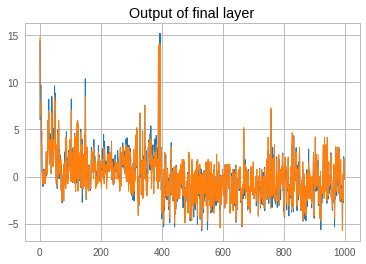

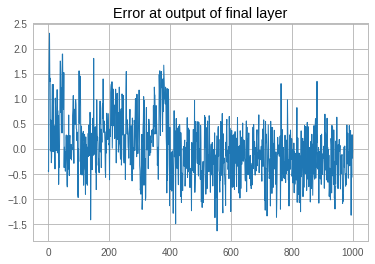

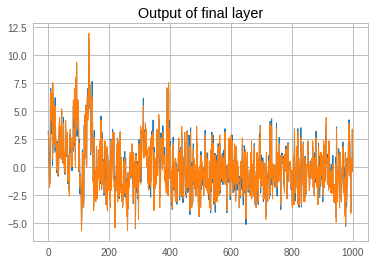

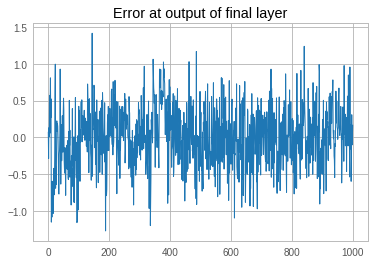

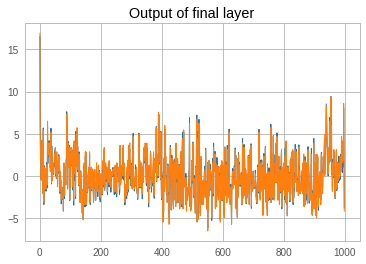

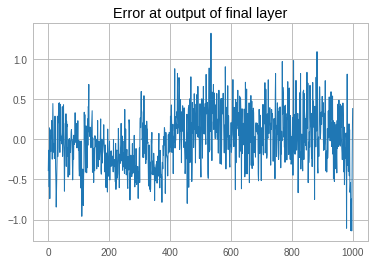

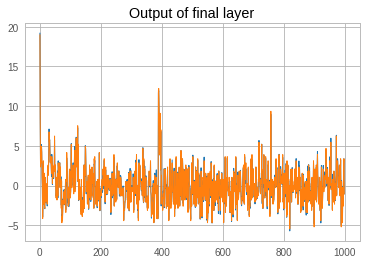

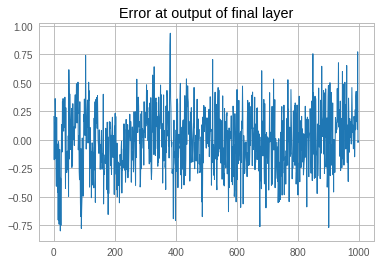

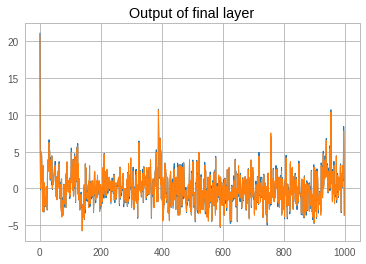

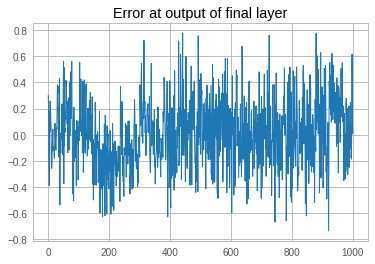

SQNR (dB) [12.73488163948059, 14.666597843170166, 16.963343620300293, 18.68514657020569, 18.769028186798096]


In [20]:
import matplotlib.pyplot as plt
SQNR = []
for i in range(len(ref_output)):

    plt.plot(ref_output[i][0].numpy())
    plt.plot(qtz_output[i][0].numpy())

    plt.title('Output of final layer')
    plt.show()
    plt.plot(ref_output[i][0].numpy().flatten() - qtz_output[i][0].numpy().flatten())
    plt.title('Error at output of final layer')
    plt.show()

    SQNR.append(20*torch.log10(torch.norm(ref_output[i][0])/torch.norm(ref_output[i][0]-qtz_output[i][0])).numpy())

print('SQNR (dB)', SQNR)

Running inference on the imagenet validation set, we get the following accuracy results:

| Model      | Top-1 (Quantized) | Top-5 (Quantized) | Top-1 (Float) | Top-5 (Float) |
| ----------- | ----------- |------------------------|---------------|---------------|
|ResNext-101 32x8|78.3	|94.3|79.3|	94.5|
| Resnet-50|       73.8| 91.7|76.1|92.9|


In [21]:
batch_size = 1
num_batches = 10
val_loader = DataLoader(get_imagenet_val_dataset(data_dir), batch_size)
elapsed = 0
for i, (images, target) in enumerate(val_loader):
    if i < num_batches:
        start = time.time()
        output = float_model(images)
        end = time.time()
        elapsed = elapsed + (end-start)
    else:
        break
print('Elapsed (float) %3.0f ms'%(elapsed/num_batches*1000))

Elapsed (float) 216 ms


In [22]:
#batch_size = 1
#num_batches = 10
#val_loader = DataLoader(get_imagenet_val_dataset(data_dir), batch_size)
elapsed = 0
for i, (images, target) in enumerate(val_loader):
    if i < num_batches:
        start = time.time()
        output = myModel(images)
        end = time.time()
        elapsed = elapsed + (end-start)
    else:
        break
print('Elapsed (quantized) %3.0f ms'%(elapsed/num_batches*1000))

Elapsed (quantized) 143 ms


The results depend on your hardware. In this run, float model took 215 ms/image while the quantized model takes 142 ms/image, which is a 1.5x speedup